<a href="https://colab.research.google.com/github/Supreeta11/Mp_Cardiovascular_Risk_Prediction/blob/main/Mp_Cardiovascular_Risk_Prediction_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from scipy.stats import chi2, chi2_contingency, f_oneway
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, recall_score, precision_score,\
 accuracy_score, roc_curve, auc, classification_report, confusion_matrix
from xgboost import XGBClassifier
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras import Sequential, layers
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.neighbors import KNeighborsClassifier

In [11]:
warnings.filterwarnings('ignore')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
file_dir = pd.read_csv('/content/drive/MyDrive/data_cardiovascular_risk.csv')


In [14]:
file_dir.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3390 entries, 0 to 3389
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               3390 non-null   int64  
 1   age              3390 non-null   int64  
 2   education        3303 non-null   float64
 3   sex              3390 non-null   object 
 4   is_smoking       3390 non-null   object 
 5   cigsPerDay       3368 non-null   float64
 6   BPMeds           3346 non-null   float64
 7   prevalentStroke  3390 non-null   int64  
 8   prevalentHyp     3390 non-null   int64  
 9   diabetes         3390 non-null   int64  
 10  totChol          3352 non-null   float64
 11  sysBP            3390 non-null   float64
 12  diaBP            3390 non-null   float64
 13  BMI              3376 non-null   float64
 14  heartRate        3389 non-null   float64
 15  glucose          3086 non-null   float64
 16  TenYearCHD       3390 non-null   int64  
dtypes: float64(9),

In [15]:
# lets check for distribution of classes
class_0_count, class_1_count = file_dir[file_dir['TenYearCHD']==0].shape[0], file_dir[file_dir['TenYearCHD']==1].shape[0]
print('Class imbalance = %d: %d' % (class_0_count, class_1_count)) # need to address this after some EDA

Class imbalance = 2879: 511


There are 17 columns in the dataset. Out of which 15 are attributes/features, column 0 is the id of each sample, and column 16 is the target variable. Before doing some data cleaning and EDA, lets split our dataset into train and test data.<br>

In [17]:
train_file_dir, test_file_dir = train_test_split(file_dir, test_size=0.2, stratify=file_dir['TenYearCHD'], random_state = 1)

In [18]:
train_file_dir.shape

(2712, 17)

In [19]:
test_file_dir.shape

(678, 17)

# **Exploratory Data Analysis**
----------------------------------
<br>

## **Categorical Variables**

* **Data cleaning - null values imputation**

In [20]:
cat_features = ['education', 'sex', 'is_smoking', 'BPMeds', 'prevalentStroke', 'prevalentHyp', 'diabetes']

In [21]:
simp_imputer = SimpleImputer(strategy="most_frequent")
simp_imputer.fit(train_file_dir[cat_features])
train_file_dir[cat_features]= simp_imputer.transform(train_file_dir[cat_features])
test_file_dir[cat_features]= simp_imputer.transform(test_file_dir[cat_features])

### **Education**

In [22]:
train_file_dir.education.unique()

array([2.0, 3.0, 1.0, 4.0], dtype=object)

(array([0, 1, 2, 3]),
 [Text(0, 0, '1.0'), Text(1, 0, '2.0'), Text(2, 0, '3.0'), Text(3, 0, '4.0')])

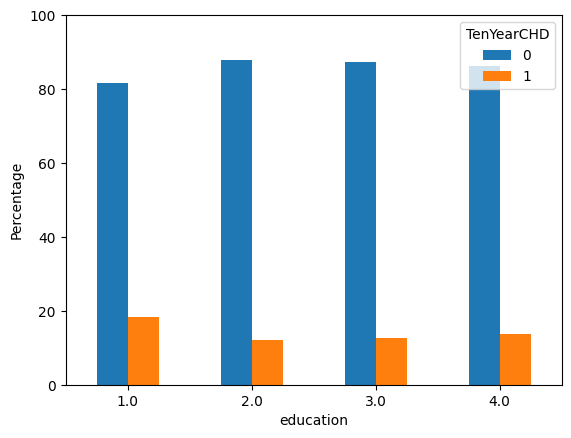

In [23]:
freq_file_dir = train_file_dir.groupby('TenYearCHD')['education'].value_counts().unstack(0)
pct_file_dir = freq_file_dir.divide(freq_file_dir.sum(axis=1), axis=0)*100
pct_file_dir.plot(kind="bar")
plt.ylim(0,100)
plt.ylabel('Percentage')
plt.xticks(rotation=0)

In [24]:
prob = 0.99
alpha = 1.0 - prob

In [25]:
# using chi-square statistic to determine any dependency between categorical variables
def cat_dependency(freq_df, alpha=alpha, verbose=True):
  stat, p, dof, expected = chi2_contingency(freq_file_dir)
  if p <= alpha:
    if verbose:
      print('significance=%.3f, p=%.7f' % (alpha, p))
      print('Categorical variables are dependent')
    return True
  else:
    if verbose:
      print('significance=%.3f, p=%.7f' % (alpha, p))
      print('Categorical variables are not dependent')
    return False

In [26]:
cat_dependency(freq_file_dir)

significance=0.010, p=0.0006802
Categorical variables are dependent


True

### **Sex**

(array([0, 1]), [Text(0, 0, 'F'), Text(1, 0, 'M')])

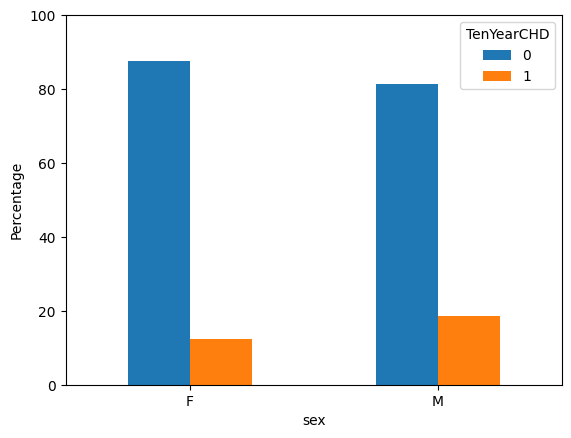

In [27]:
freq_file_dir = train_file_dir.groupby('TenYearCHD')['sex'].value_counts().unstack(0)
pct_file_dir = freq_file_dir.divide(freq_file_dir.sum(axis=1), axis=0)*100
pct_file_dir.plot(kind="bar")
plt.ylim(0,100)
plt.ylabel('Percentage')
plt.xticks(rotation=0)

In [28]:
cat_dependency(freq_file_dir)

significance=0.010, p=0.0000071
Categorical variables are dependent


True

**Higher fraction of males are prone to cardiovascular diseases!**

### **Smoking**

(array([0, 1]), [Text(0, 0, 'NO'), Text(1, 0, 'YES')])

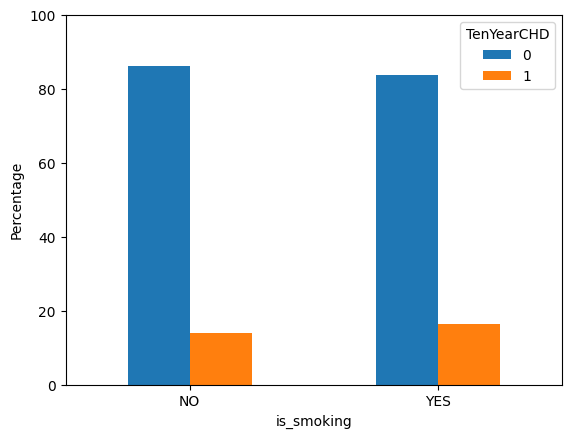

In [29]:
freq_file_dir = train_file_dir.groupby('TenYearCHD')['is_smoking'].value_counts().unstack(0)
pct_file_dir = freq_file_dir.divide(freq_file_dir.sum(axis=1), axis=0)*100
pct_file_dir.plot(kind="bar")
plt.ylim(0,100)
plt.ylabel('Percentage')
plt.xticks(rotation=0)

In [30]:
cat_dependency(freq_file_dir)

significance=0.010, p=0.0928572
Categorical variables are not dependent


False

**Statistically smoking has no impact on 10-year risk of CHD**

### **BP Meds**

In [31]:
train_file_dir.BPMeds.unique()

array([0.0, 1.0], dtype=object)

(array([0, 1]), [Text(0, 0, '0.0'), Text(1, 0, '1.0')])

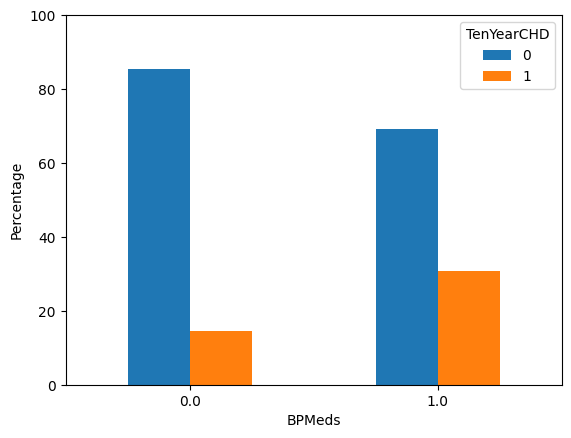

In [32]:
freq_file_dir = train_file_dir.groupby('TenYearCHD')['BPMeds'].value_counts().unstack(0)
pct_file_dir = freq_file_dir.divide(freq_file_dir.sum(axis=1), axis=0)*100
pct_file_dir.plot(kind="bar")
plt.ylim(0,100)
plt.ylabel('Percentage')
plt.xticks(rotation=0)

In [33]:
cat_dependency(freq_file_dir)

significance=0.010, p=0.0001078
Categorical variables are dependent


True

**People who take Blood pressure meds have a higher chance of having CHD**

### **Prevalent Stroke**

In [34]:
train_file_dir.prevalentStroke.unique()

array([0, 1], dtype=object)

(array([0, 1]), [Text(0, 0, '0'), Text(1, 0, '1')])

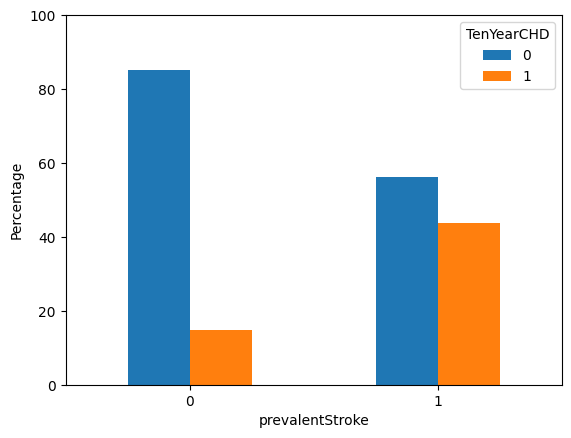

In [35]:
freq_file_dir = train_file_dir.groupby('TenYearCHD')['prevalentStroke'].value_counts().unstack(0)
pct_file_dir = freq_file_dir.divide(freq_file_dir.sum(axis=1), axis=0)*100
pct_file_dir.plot(kind="bar")
plt.ylim(0,100)
plt.ylabel('Percentage')
plt.xticks(rotation=0)

In [36]:
cat_dependency(freq_file_dir)

significance=0.010, p=0.0041885
Categorical variables are dependent


True

**Higher percentage of patients with prevalent stroke symptoms have a 10-year risk of CHD.**

### **Prevalent Hypertension**

In [37]:
train_file_dir.prevalentHyp.unique()

array([0, 1], dtype=object)

(array([0, 1]), [Text(0, 0, '0'), Text(1, 0, '1')])

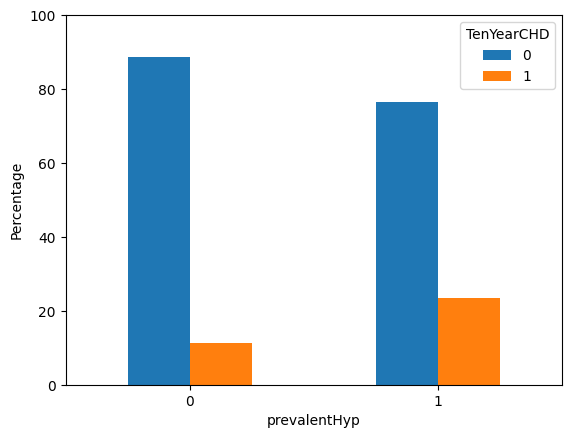

In [38]:
freq_file_dir = train_file_dir.groupby('TenYearCHD')['prevalentHyp'].value_counts().unstack(0)
pct_file_dir = freq_file_dir.divide(freq_file_dir.sum(axis=1), axis=0)*100
pct_file_dir.plot(kind="bar")
plt.ylim(0,100)
plt.ylabel('Percentage')
plt.xticks(rotation=0)

In [39]:
cat_dependency(freq_file_dir)

significance=0.010, p=0.0000000
Categorical variables are dependent


True

**Hypertensive patients are at higher risk of CHD**

### **Diabetes**

In [40]:
train_file_dir.diabetes.unique()

array([0, 1], dtype=object)

(array([0, 1]), [Text(0, 0, '0'), Text(1, 0, '1')])

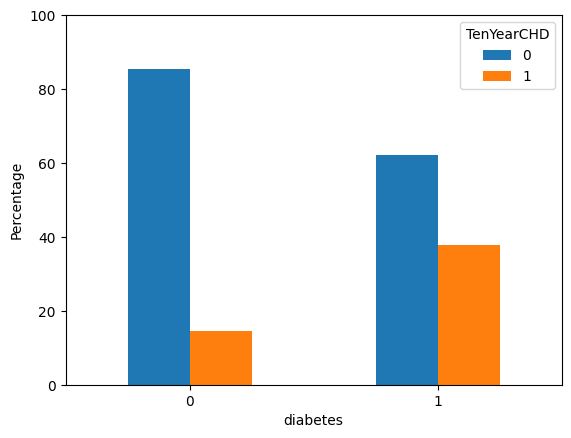

In [41]:
freq_file_dir = train_file_dir.groupby('TenYearCHD')['diabetes'].value_counts().unstack(0)
pct_file_dir = freq_file_dir.divide(freq_file_dir.sum(axis=1), axis=0)*100
pct_file_dir.plot(kind="bar")
plt.ylim(0,100)
plt.ylabel('Percentage')
plt.xticks(rotation=0)

In [42]:
cat_dependency(freq_file_dir)

significance=0.010, p=0.0000004
Categorical variables are dependent


True

**Diabetic patients tend to have a higher 10-year risk of CHD**


## **Continuous Variables**

* **Data cleaning - null values imputation**

In [43]:
cont_features = ['age', 'totChol', 'cigsPerDay', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose']

In [44]:
knn_imputer= KNNImputer(n_neighbors=5)
knn_imputer.fit(train_file_dir[cont_features])
train_file_dir[cont_features]= knn_imputer.transform(train_file_dir[cont_features])
test_file_dir[cont_features]= knn_imputer.transform(test_file_dir[cont_features])

### **Age**

In [45]:
train_file_dir.age.unique()

array([49., 51., 57., 59., 52., 60., 48., 40., 54., 39., 56., 44., 42.,
       43., 41., 45., 37., 61., 53., 62., 47., 36., 55., 34., 46., 64.,
       38., 58., 63., 35., 50., 65., 67., 66., 68., 33., 69., 70., 32.])

<Axes: xlabel='TenYearCHD', ylabel='age'>

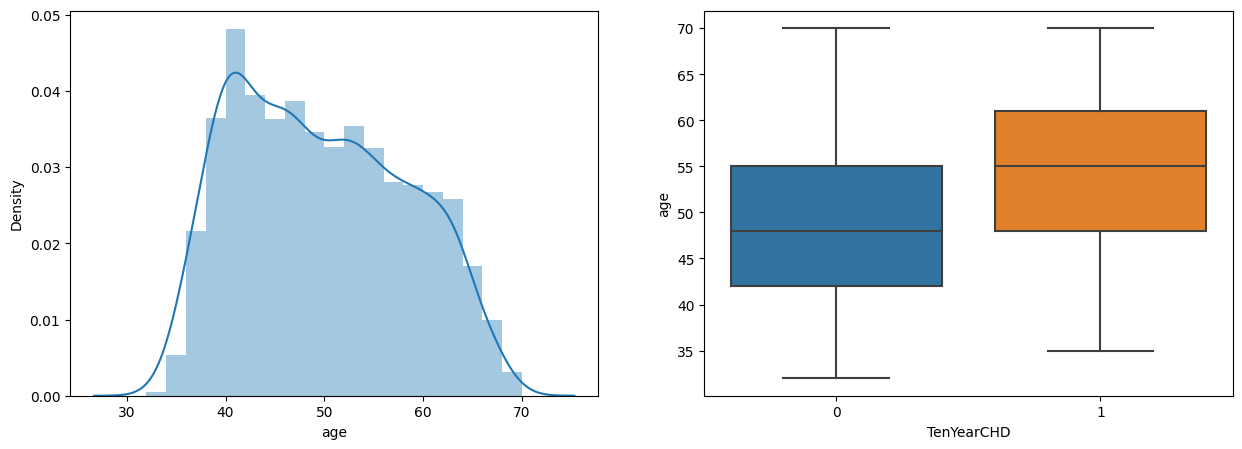

In [46]:
fig, axes = plt.subplots(1,2,figsize=(15,5))
sns.distplot(train_file_dir['age'], ax=axes[0])
sns.boxplot(y='age',x='TenYearCHD',data=train_file_dir, ax=axes[1])

In [47]:
# using one-way ANOVA test to determine dependency between continuous variables and the target categorical variable
def cont_dependency(feature,alpha=alpha):
  F, p = f_oneway(train_file_dir[train_file_dir['TenYearCHD'] == 1][feature], train_file_dir[train_file_dir['TenYearCHD'] == 0][feature])
  print('significance=%.3f, p=%.5f' % (alpha, p))
  if p <= alpha:
    print('Ten year Risk of CHD is dependent on the continuous variable')
    return True
  else:
    print('Ten year Risk of CHD is not dependent on continuous variable')
    return False

In [48]:
cont_dependency('age')

significance=0.010, p=0.00000
Ten year Risk of CHD is dependent on the continuous variable


True

**Bucketing age feature**

In [49]:
train_file_dir['age_bucket'] = train_file_dir['age'].apply(lambda x : 5*(x//5))

In [51]:
pip install -U seaborn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [56]:
ax=sns.factorplot('age_bucket', 'TenYearCHD', kind='bar', data = train_file_dir, size=4, aspect=1.5)
ax.set_ylabels('CHD Probability')

AttributeError: ignored

**The positive CHD cases seems to be more prevalent in older people.**

### **Cigarrettes per Day**

<Axes: xlabel='TenYearCHD', ylabel='cigsPerDay'>

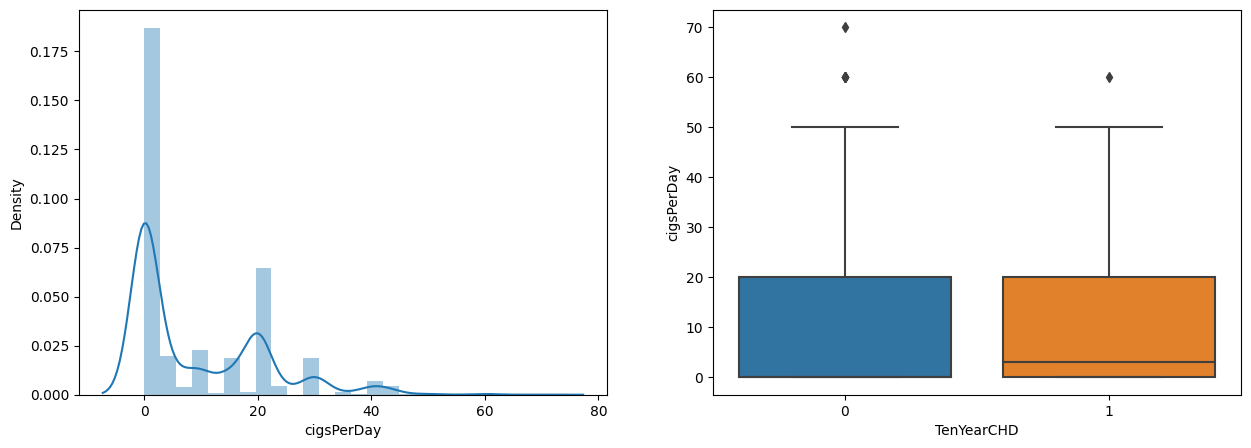

In [58]:
fig, axes = plt.subplots(1,2,figsize=(15,5))
sns.distplot(train_file_dir['cigsPerDay'], ax=axes[0])
sns.boxplot(y='cigsPerDay',x='TenYearCHD',data=train_file_dir, ax=axes[1])

In [59]:
cont_dependency('cigsPerDay')

significance=0.010, p=0.00184
Ten year Risk of CHD is dependent on the continuous variable


True

**We see that the median is slighlty higher for the positive cases, which means people who smoke higher number of cigarette per day, tend to show cardio-vascular disease!**

### **Total Cholestrol level**

<Axes: xlabel='TenYearCHD', ylabel='totChol'>

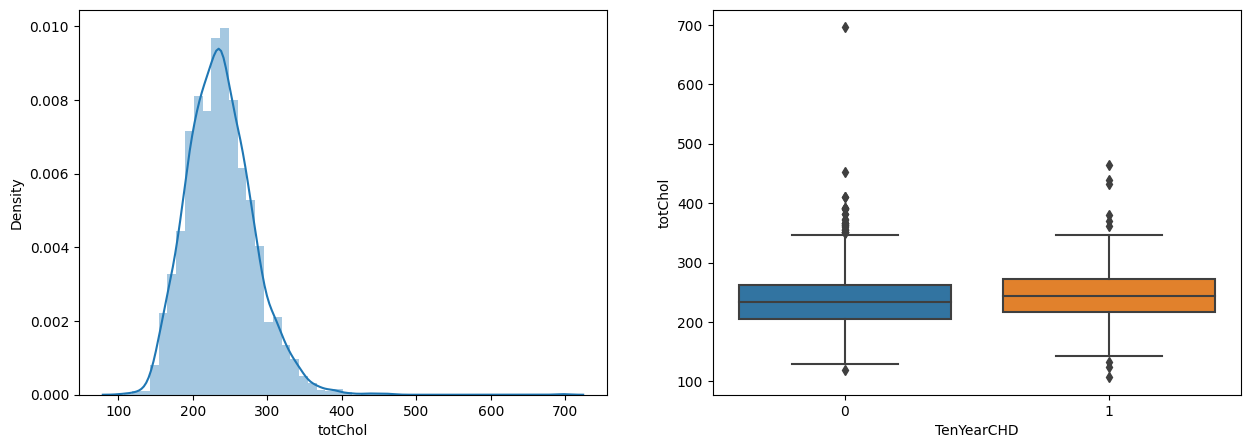

In [61]:
fig, axes = plt.subplots(1,2,figsize=(15,5))
sns.distplot(train_file_dir['totChol'], ax=axes[0])
sns.boxplot(y='totChol',x='TenYearCHD',data=train_file_dir, ax=axes[1])

In [63]:
#dealing with outliers
vals = train_file_dir.totChol.quantile([0.25,0.75])
print(vals)
iqr = vals.values[1] - vals.values[0]
min_lim, max_lim = vals.values[0] - 1.5*iqr, vals.values[1] + 1.5*iqr
train_file_dir['totChol'] = train_file_dir['totChol'].apply(lambda x : x if x > min_lim and x < max_lim else train_file_dir['totChol'].median())

0.25    206.00
0.75    264.25
Name: totChol, dtype: float64


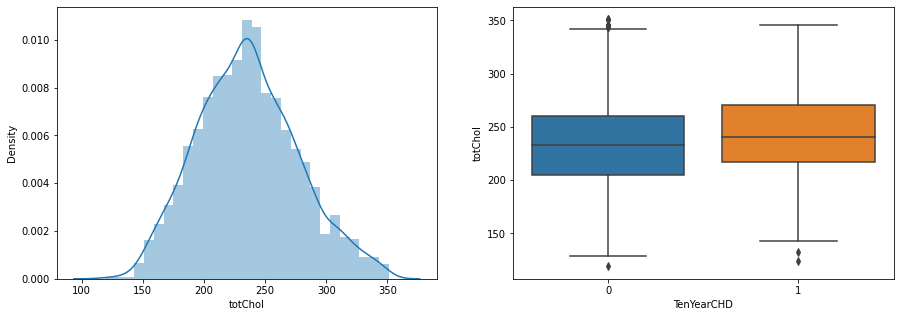

In [ ]:
fig, axes = plt.subplots(1,2,figsize=(15,5))
sns.distplot(train_df['totChol'], ax=axes[0])
sns.boxplot(y='totChol',x='TenYearCHD',data=train_df, ax=axes[1])

In [64]:
cont_dependency('totChol')

significance=0.010, p=0.00000
Ten year Risk of CHD is dependent on the continuous variable


True

**Bucketing Total cholestrol feature**

In [65]:
train_file_dir['chol_bucket'] = train_file_dir['totChol'].apply(lambda x : 40*(x//40))

In [66]:
ax = sns.factorplot('chol_bucket', 'TenYearCHD', kind='bar', data = train_file_dir, size=4, aspect=1.5)
ax.set_ylabels('CHD Probability')

AttributeError: ignored

### **Systolic and diastolic BP**

<Axes: xlabel='TenYearCHD', ylabel='diaBP'>

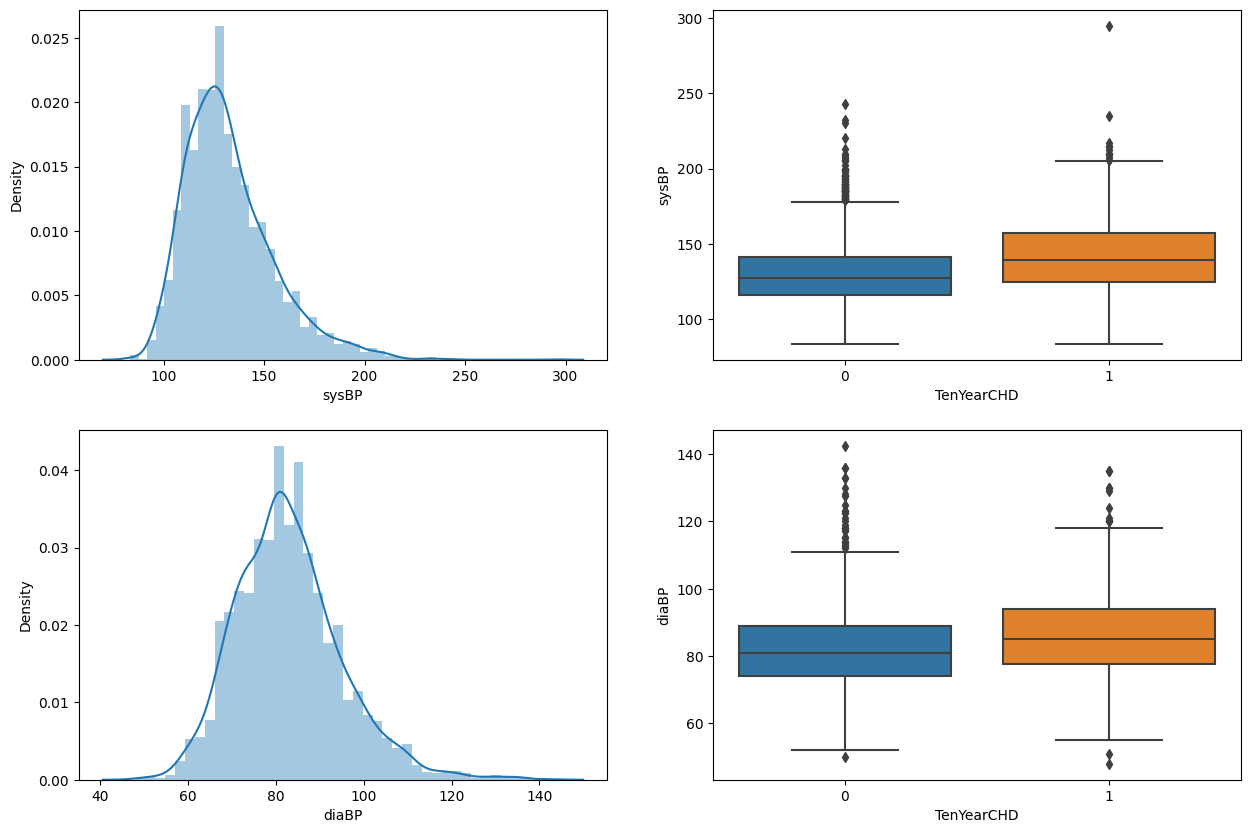

In [67]:
fig, axes = plt.subplots(2,2,figsize=(15,10))
sns.distplot(train_file_dir['sysBP'], ax=axes[0,0])
sns.boxplot(y='sysBP',x='TenYearCHD',data=train_file_dir, ax=axes[0,1])
sns.distplot(train_file_dir['diaBP'], ax=axes[1,0])
sns.boxplot(y='diaBP',x='TenYearCHD',data=train_file_dir, ax=axes[1,1])

In [68]:
cont_dependency('sysBP')

significance=0.010, p=0.00000
Ten year Risk of CHD is dependent on the continuous variable


True

In [69]:
cont_dependency('diaBP')

significance=0.010, p=0.00000
Ten year Risk of CHD is dependent on the continuous variable


True

**Bucketing Systolic BP feature**

In [70]:
train_file_dir['sysBP_bucket'] = train_file_dir['sysBP'].apply(lambda x : 30*(x//30))

In [72]:
ax = sns.factorplot('sysBP_bucket', 'TenYearCHD', kind='bar', data = train_file_dir, size=4, aspect=1.5)
ax.set_ylabels('CHD Probability')

AttributeError: ignored

**We see a slighlty positive inclination of CHD risk towards high systolic and diastolic Blood pressure.**

### **Body Mass Index (BMI)**

<Axes: xlabel='TenYearCHD', ylabel='BMI'>

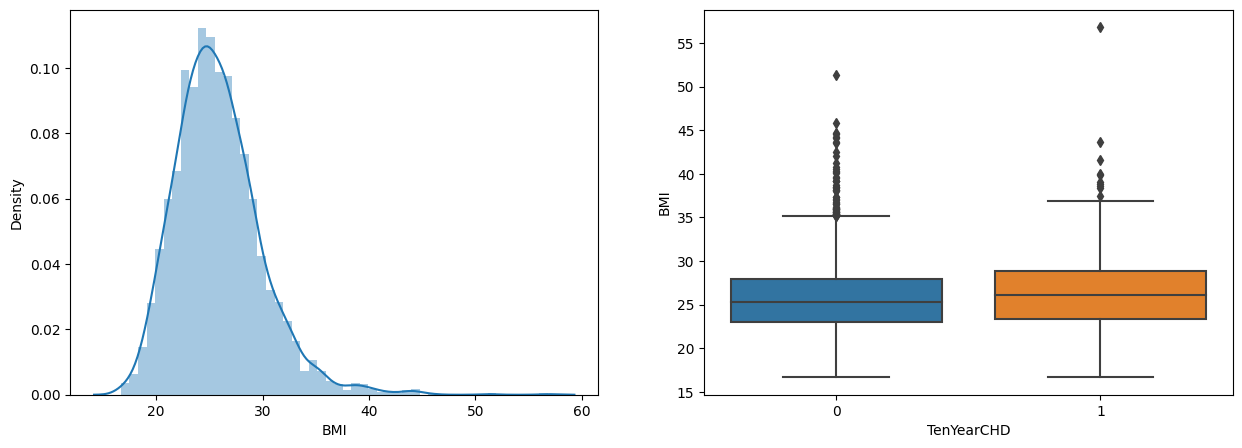

In [73]:
fig, axes = plt.subplots(1,2,figsize=(15,5))
sns.distplot(train_file_dir['BMI'], ax=axes[0])
sns.boxplot(y='BMI',x='TenYearCHD',data=train_file_dir, ax=axes[1])

In [74]:
cont_dependency('BMI')

significance=0.010, p=0.00279
Ten year Risk of CHD is dependent on the continuous variable


True

**Bucketing BMI feature**

In [75]:
train_file_dir['bmi_bucket'] = train_file_dir['BMI'].apply(lambda x : 3*(x//3))

In [77]:
ax = sns.factorplot('bmi_bucket', 'TenYearCHD', kind='bar', data = train_file_dir, size=4, aspect=1.5)
ax.set_ylabels('CHD Probability')

AttributeError: ignored

### **Heart Rate**

<Axes: xlabel='TenYearCHD', ylabel='heartRate'>

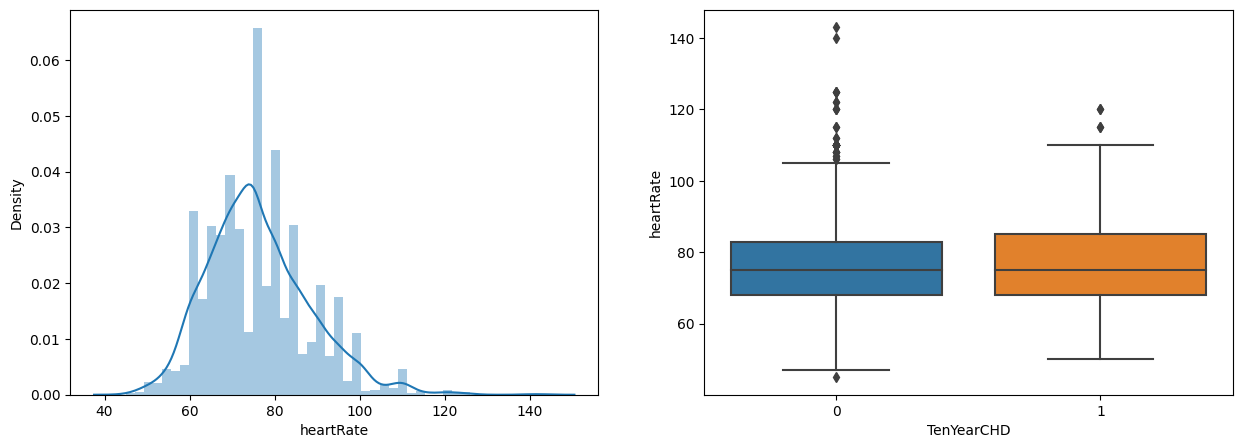

In [78]:
fig, axes = plt.subplots(1,2,figsize=(15,5))
sns.distplot(train_file_dir['heartRate'], ax=axes[0])
sns.boxplot(y='heartRate',x='TenYearCHD',data=train_file_dir, ax=axes[1])

In [79]:
cont_dependency('heartRate')

significance=0.010, p=0.16756
Ten year Risk of CHD is not dependent on continuous variable


False

**Bucketing heart Rate Feature**

In [80]:
train_file_dir['hr_bucket'] = train_file_dir['heartRate'].apply(lambda x : 10*(x//10))

In [81]:
ax = sns.factorplot('hr_bucket', 'TenYearCHD', kind='bar', data = train_file_dir, size=4, aspect=1.5)
ax.set_ylabels('CHD Probability')

AttributeError: ignored

### **Glucose**

<Axes: xlabel='TenYearCHD', ylabel='glucose'>

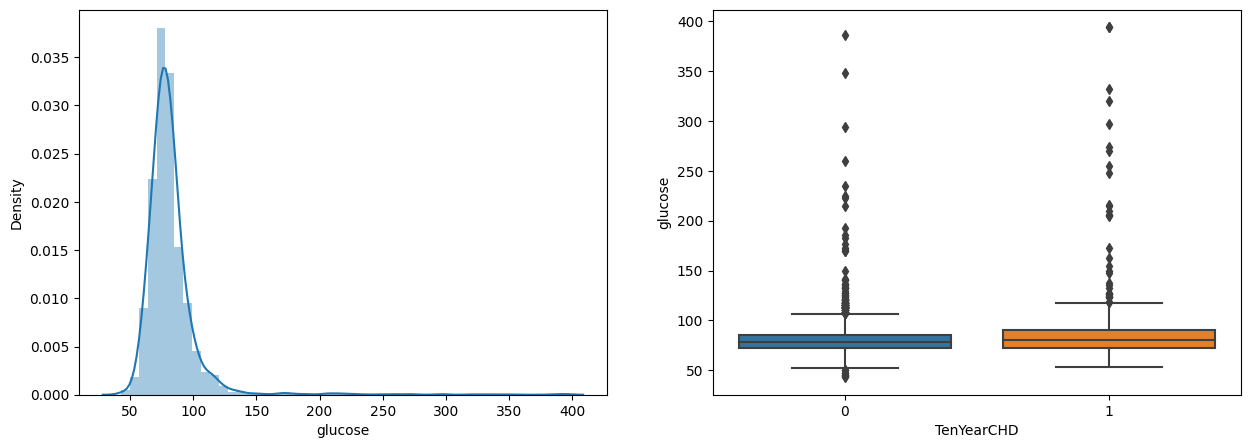

In [82]:
fig, axes = plt.subplots(1,2,figsize=(15,5))
sns.distplot(train_file_dir['glucose'], ax=axes[0])
sns.boxplot(y='glucose',x='TenYearCHD',data=train_file_dir, ax=axes[1])

In [83]:
cont_dependency('glucose')

significance=0.010, p=0.00000
Ten year Risk of CHD is dependent on the continuous variable


True

In [84]:
train_file_dir['glucose_bucket'] = train_file_dir['glucose'].apply(lambda x : 50*(x//50))

In [85]:
ax = sns.factorplot('glucose_bucket', 'TenYearCHD', kind='bar', data = train_file_dir, size=4, aspect=1.5)
ax.set_ylabels('CHD Probability')

AttributeError: ignored

In [86]:
train_file_dir.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2712 entries, 542 to 682
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               2712 non-null   int64  
 1   age              2712 non-null   float64
 2   education        2712 non-null   object 
 3   sex              2712 non-null   object 
 4   is_smoking       2712 non-null   object 
 5   cigsPerDay       2712 non-null   float64
 6   BPMeds           2712 non-null   object 
 7   prevalentStroke  2712 non-null   object 
 8   prevalentHyp     2712 non-null   object 
 9   diabetes         2712 non-null   object 
 10  totChol          2712 non-null   float64
 11  sysBP            2712 non-null   float64
 12  diaBP            2712 non-null   float64
 13  BMI              2712 non-null   float64
 14  heartRate        2712 non-null   float64
 15  glucose          2712 non-null   float64
 16  TenYearCHD       2712 non-null   int64  
 17  age_bucket   

# **Dependencies between Independent variables - Check for multicollinearity**

In [87]:
def cat_dependency_matrix(cols, alpha=alpha, verbose=False):
  cat_matrix = np.zeros((cols.shape[0], cols.shape[0]))
  print(cat_matrix.shape)
  for i,col in enumerate(cols):
    for j,col in enumerate(cols):
      if i != j:
        cat_matrix[i,j] = int(cat_dependency(train_file_dir.groupby(cols[j])[cols[i]].value_counts().unstack(0), alpha=alpha, verbose=verbose))
      else:
        cat_matrix[i,j] = 1.
  return pd.DataFrame(cat_matrix, columns=cols, index=cols, dtype=int)

In [88]:
cat_cols = np.array(['education', 'sex', 'is_smoking', 'BPMeds', 'prevalentStroke', 'prevalentHyp', 'diabetes'])
cat_dependency_matrix(cat_cols, alpha=0.01, verbose=False)

(7, 7)


,education,sex,is_smoking,BPMeds,prevalentStroke,prevalentHyp,diabetes
education,1,1,1,1,1,1,1
sex,1,1,1,1,1,1,1
is_smoking,1,1,1,1,1,1,1
BPMeds,1,1,1,1,1,1,1
prevalentStroke,1,1,1,1,1,1,1
prevalentHyp,1,1,1,1,1,1,1
diabetes,1,1,1,1,1,1,1


**Lets look at correlation matrix of categorical variables as well !**

<Axes: >

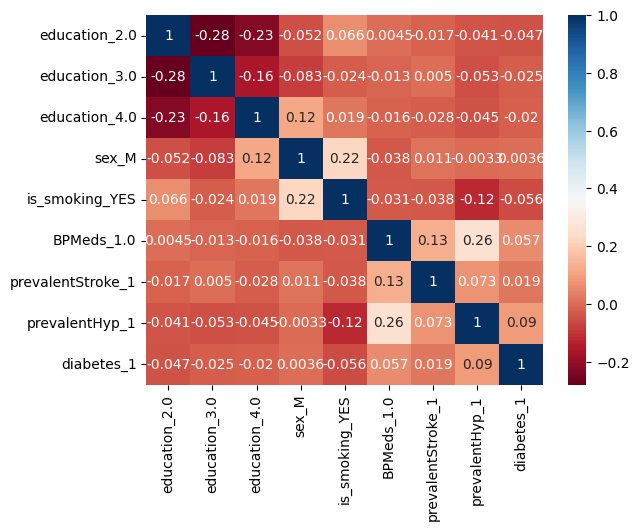

In [89]:
train_cat_file_dir = pd.get_dummies(train_file_dir[cat_cols], drop_first=True)
sns.heatmap(train_cat_file_dir.corr(), cmap='RdBu', annot=True)

In [90]:
#lets check vif scores
def calc_vif(X):
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return(vif)

In [91]:
ignore_features = ['education']
train_cat_file_dir_ = train_cat_file_dir[[col for col in train_cat_file_dir.columns if col not in ignore_features]]
calc_vif(train_cat_file_dir_)

,variables,VIF
0,education_2.0,0.006790
1,education_3.0,0.480280
2,education_4.0,0.213605
3,sex_M,0.198403
4,is_smoking_YES,0.086462
5,BPMeds_1.0,1.123641
6,prevalentStroke_1,1.025972
7,prevalentHyp_1,0.127765
8,diabetes_1,1.030739


**Based on the VIF scores, I can safely remove education feature.**

**Lets look at correlation matrix of Continuous variables**

<Axes: >

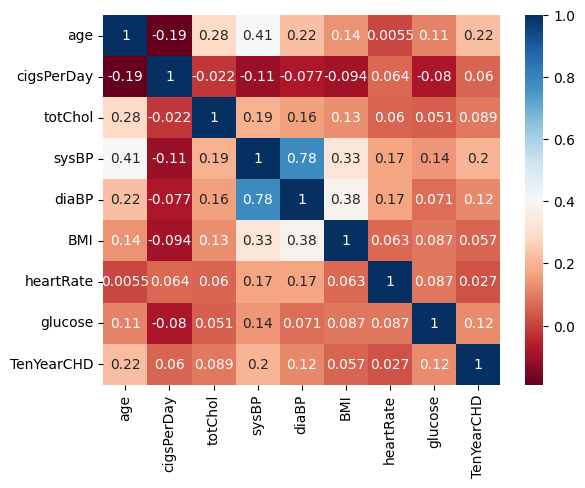

In [92]:
cont_cols = np.array(['age', 'cigsPerDay', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose', 'TenYearCHD'])
sns.heatmap(train_file_dir[cont_cols].corr(), cmap='RdBu', annot=True)

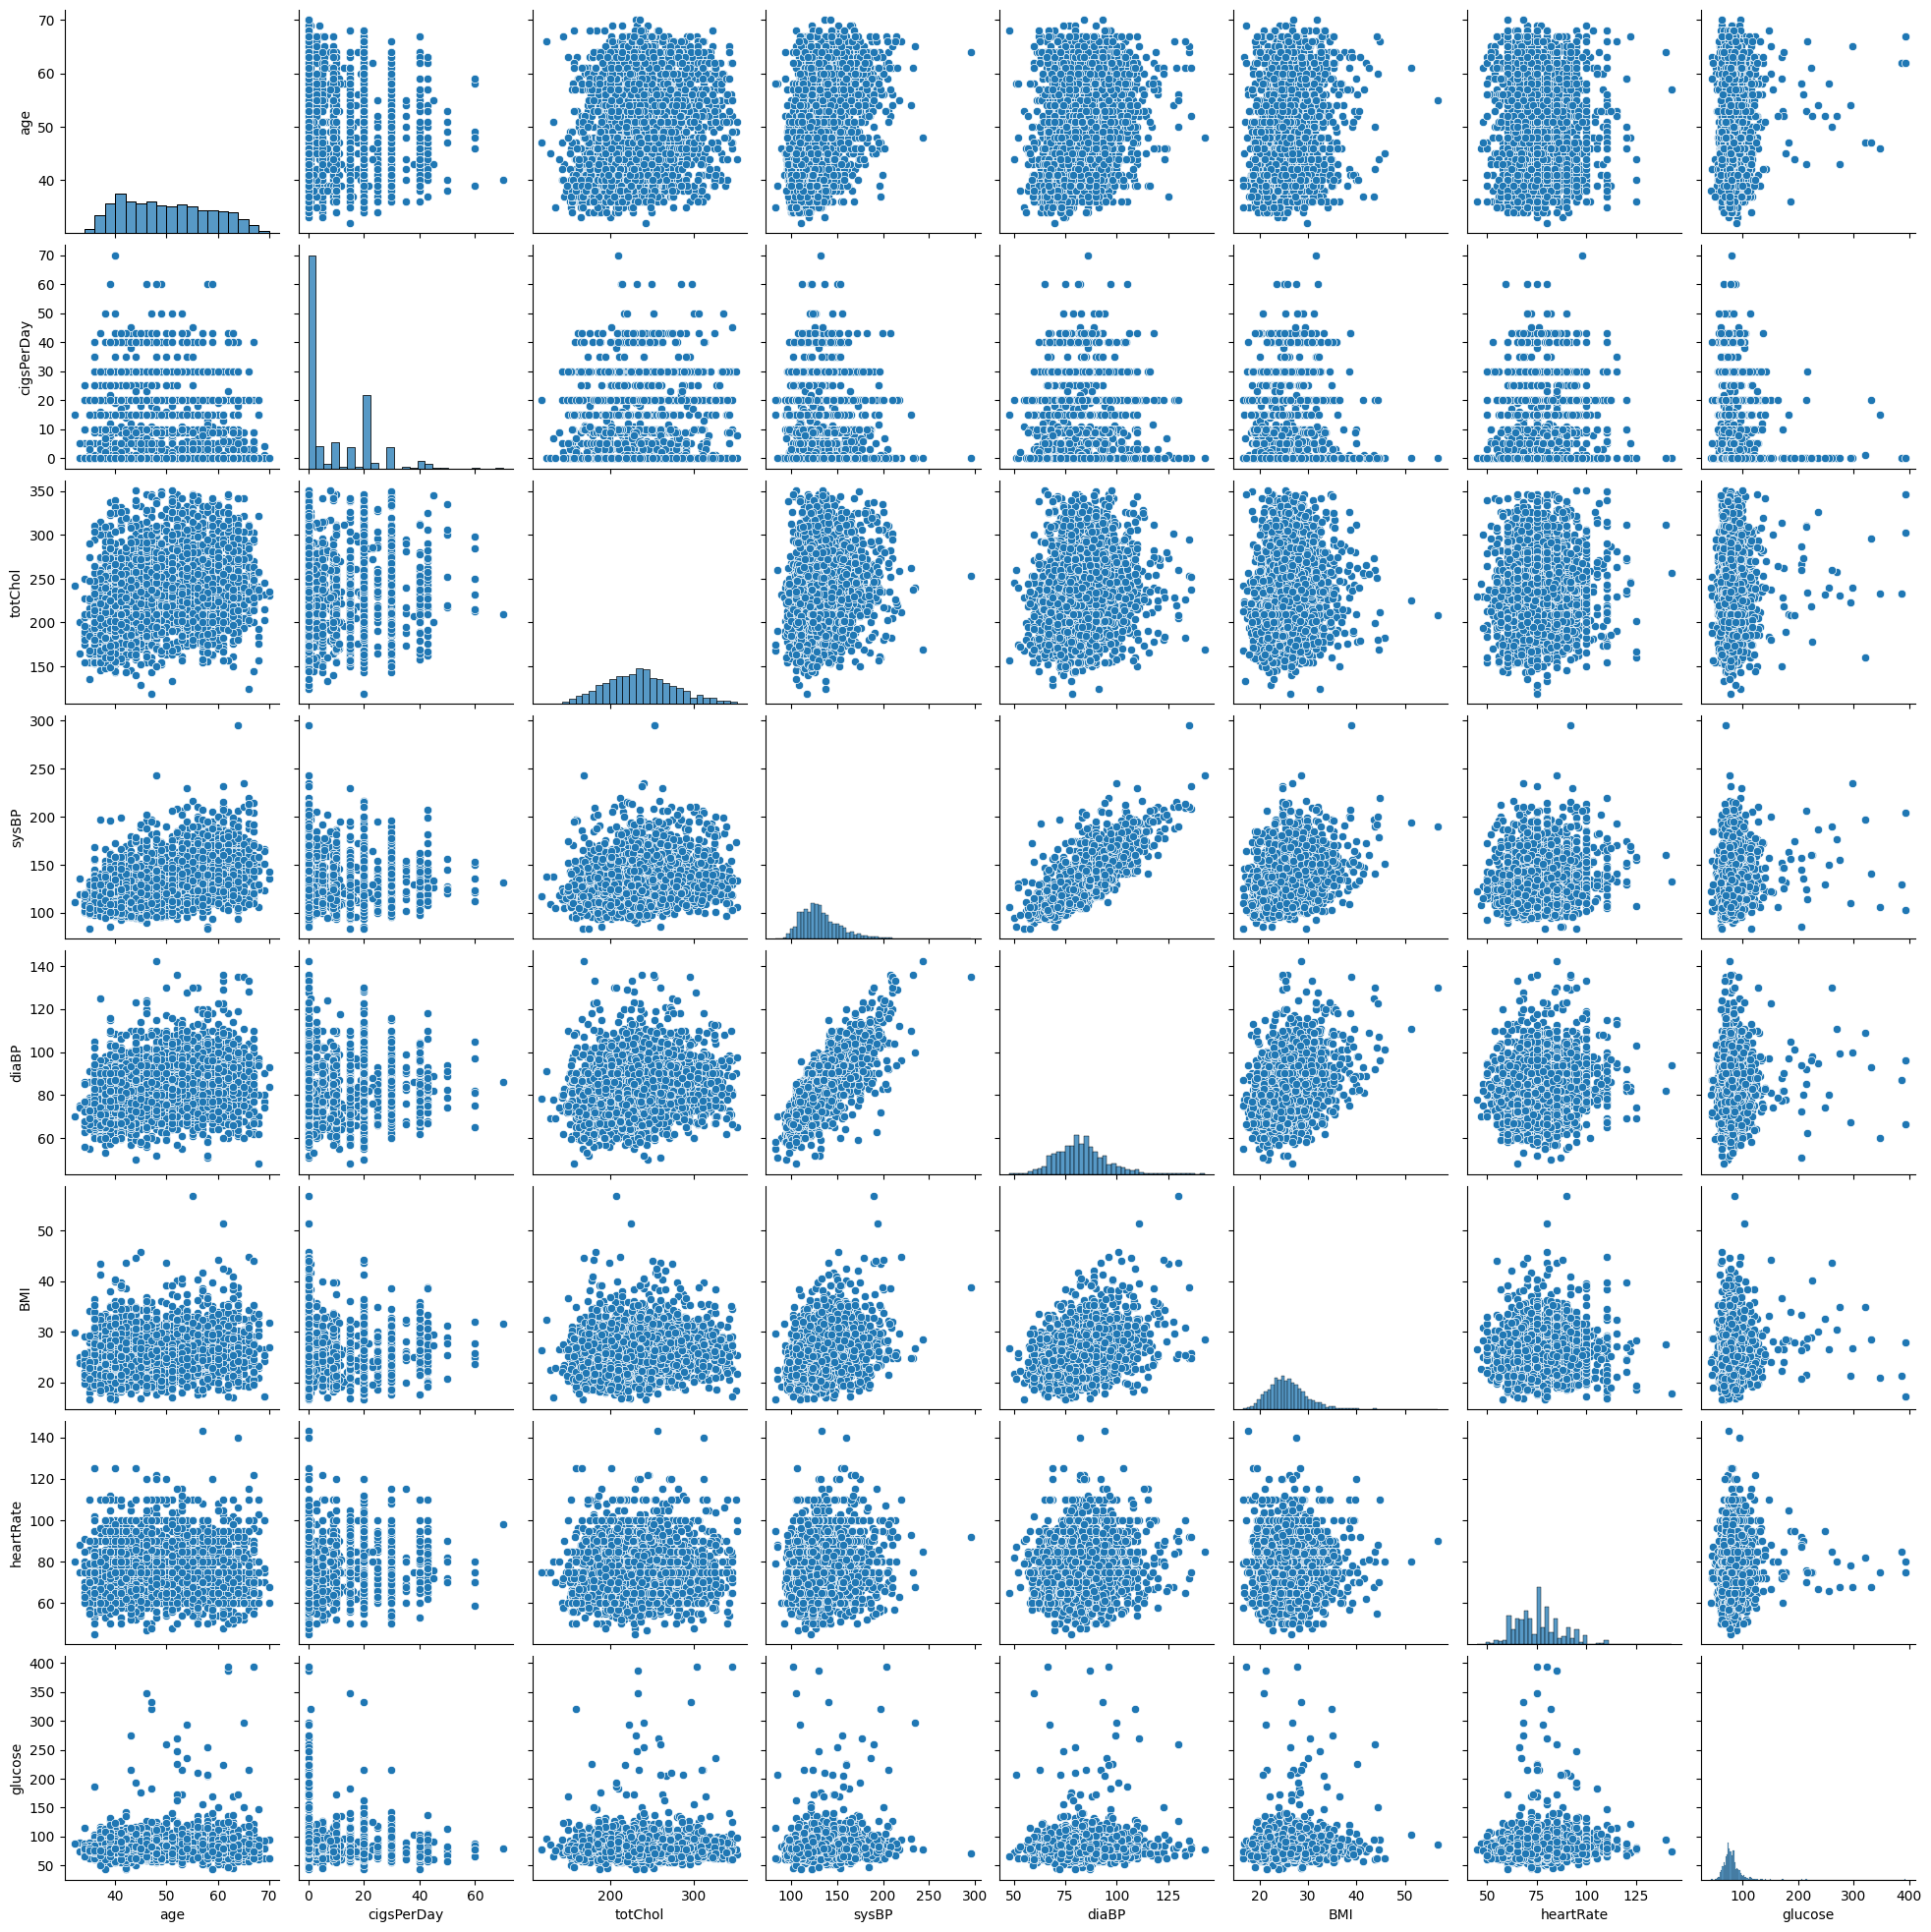

In [93]:
sns.pairplot(train_file_dir[cont_cols[:-1]])

In [94]:
ignore_features = ['TenYearCHD','diaBP']
train_cont_file_dir = train_file_dir[[col for col in cont_cols if col not in ignore_features]]
calc_vif(train_cont_file_dir)

,variables,VIF
0,age,41.049805
1,cigsPerDay,1.621425
2,totChol,34.108171
3,sysBP,49.471280
4,BMI,39.070687
5,heartRate,33.297511
6,glucose,13.291682


**There was a significantly higher correlation between systolic BP and diastolic BP. Based on correlation matrix and VIF scores, I safely remove diabolic BP feature.**

**Lets look at the correlation matrix of all the remaining features and see if there are any correlations left**

<Axes: >

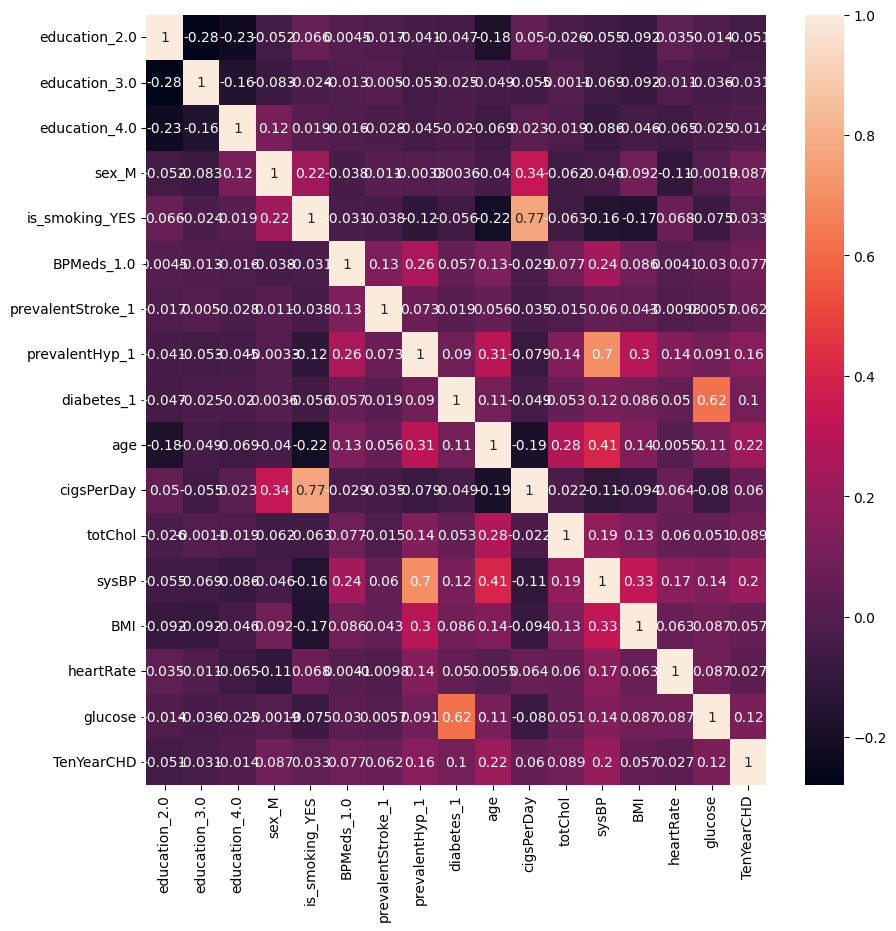

In [95]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
tot_file_dir = pd.concat((train_cat_file_dir_, train_cont_file_dir, train_file_dir['TenYearCHD']), axis =1)
sns.heatmap(tot_file_dir.corr(), annot=True, ax= ax)

**There is significant correlation between sysBP, prevalent hypertension and age. Also features like is smoking and ciggarettes per day are correlated. Similarly glucose level and diabetes are correlated. Based on the EDA done earlier, smoking and heart Rate seem to have little to no impact on the target variable.**

**Preparing final train dataset**

In [103]:
final_features = np.concatenate((train_cat_file_dir_.columns.values, train_cont_file_dir.columns.values, ['diaBP','TenYearCHD']))

In [104]:
#imputer = KNNImputer(n_neighbors=5)
final_train_file_dir = pd.get_dummies(train_file_dir,drop_first=True)[final_features]
#s = imputer.fit_transform(final_train_df)
#final_train_df = pd.DataFrame(s, columns = final_train_df.columns)

In [105]:
final_train_file_dir.head()

,education_2.0,education_3.0,education_4.0,sex_M,is_smoking_YES,BPMeds_1.0,prevalentStroke_1,prevalentHyp_1,diabetes_1,age,cigsPerDay,totChol,sysBP,BMI,heartRate,glucose,diaBP,TenYearCHD
542,1,0,0,0,1,0,0,0,0,49.0,20.0,229.0,118.5,21.42,76.0,76.4,76.5,0
2726,0,1,0,1,0,0,0,0,0,51.0,0.0,215.0,147.0,28.59,65.0,100.0,96.0,0
3067,0,0,0,0,1,0,0,1,0,57.0,1.0,254.0,146.5,41.61,72.0,85.0,81.0,1
204,0,0,1,0,0,1,0,1,0,59.0,0.0,282.0,135.0,28.96,72.0,89.0,87.0,0
329,0,0,0,0,0,0,0,0,0,52.0,0.0,275.0,112.0,25.68,80.0,80.4,71.0,0


In [106]:
final_train_file_dir.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2712 entries, 542 to 682
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   education_2.0      2712 non-null   uint8  
 1   education_3.0      2712 non-null   uint8  
 2   education_4.0      2712 non-null   uint8  
 3   sex_M              2712 non-null   uint8  
 4   is_smoking_YES     2712 non-null   uint8  
 5   BPMeds_1.0         2712 non-null   uint8  
 6   prevalentStroke_1  2712 non-null   uint8  
 7   prevalentHyp_1     2712 non-null   uint8  
 8   diabetes_1         2712 non-null   uint8  
 9   age                2712 non-null   float64
 10  cigsPerDay         2712 non-null   float64
 11  totChol            2712 non-null   float64
 12  sysBP              2712 non-null   float64
 13  BMI                2712 non-null   float64
 14  heartRate          2712 non-null   float64
 15  glucose            2712 non-null   float64
 16  diaBP              2712

**Preparing our test dataset based on the selected features and the imputed missing values from training dataset.**

In [107]:
final_test_file_dir = pd.get_dummies(test_file_dir,drop_first=True)[final_features]
#s = imputer.transform(final_test_df)
#final_test_df = pd.DataFrame(s, columns = final_test_df.columns)

In [108]:
X_train, y_train = final_train_file_dir.iloc[:,:-1], final_train_file_dir.iloc[:,-1]
X_test, y_test = final_test_file_dir.iloc[:,:-1], final_test_file_dir.iloc[:,-1]

In [109]:
scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train.values), columns = X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test.values), columns=X_test.columns)

### **ML Modelling and addressing Class imbalance**

**Logistic Regression**

* **Random oversampler + Logistic Regression**

In [110]:
ros = RandomOverSampler(random_state=42)
X_ros, y_ros = ros.fit_resample(X_train, y_train)

In [111]:
lr_model = LogisticRegression().fit(X_ros, y_ros)
X_ros = pd.DataFrame(X_ros, columns = X_train.columns)
lr_y_predict = lr_model.predict(X_test)

print('ROCAUC score:', roc_auc_score(y_test, lr_y_predict))
print('Recall score:',recall_score(y_test, lr_y_predict))
print('\n', classification_report(y_test, lr_y_predict))
print('\n', confusion_matrix(y_test, lr_y_predict))

ROCAUC score: 0.6811172385620915
Recall score: 0.6764705882352942

               precision    recall  f1-score   support

           0       0.92      0.69      0.79       576
           1       0.28      0.68      0.39       102

    accuracy                           0.68       678
   macro avg       0.60      0.68      0.59       678
weighted avg       0.83      0.68      0.73       678


 [[395 181]
 [ 33  69]]


 * **StratifiedKFold + oversampling + logistic regression**

In [112]:
lr_model = LogisticRegression()
kf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
i=0
for train_index, valid_index in kf.split(X_train,y_train):
  X_train_cv, X_test_cv, y_train_cv, y_test_cv = X_train.values[train_index,:], X_train.values[valid_index,:], y_train.values[train_index], y_train.values[valid_index]
  ros = RandomOverSampler(random_state=42)
  X_ros, y_ros = ros.fit_resample(X_train_cv, y_train_cv)
  lr_model.fit(X_ros, y_ros)
  lr_predict = lr_model.predict(X_test_cv)
  print(f'CV {i+1}: ', recall_score(y_test_cv, lr_predict))
  i+=1

lr_y_predict = lr_model.predict(X_test)
print('\nTest results:')
print('ROCAUC score:', roc_auc_score(y_test, lr_y_predict))
print('Recall score:',recall_score(y_test, lr_y_predict))
print('\n', classification_report(y_test, lr_y_predict))

CV 1:  0.6097560975609756
CV 2:  0.6951219512195121
CV 3:  0.7037037037037037
CV 4:  0.6707317073170732
CV 5:  0.6585365853658537

Test results:
ROCAUC score: 0.6874489379084967
Recall score: 0.696078431372549

               precision    recall  f1-score   support

           0       0.93      0.68      0.78       576
           1       0.28      0.70      0.40       102

    accuracy                           0.68       678
   macro avg       0.60      0.69      0.59       678
weighted avg       0.83      0.68      0.73       678



* **SMOTE + Logistic Regression**

In [113]:
smote = SMOTE()
X_smote, y_smote = smote.fit_resample(X_train, y_train)
lr_model = LogisticRegression().fit(X_smote, y_smote)
X_smote = pd.DataFrame(X_smote, columns = X_train.columns)
lr_y_predict = lr_model.predict(X_test)

print('ROCAUC score:', roc_auc_score(y_test, lr_y_predict))
print('Recall score:',recall_score(y_test, lr_y_predict))
print('\n', classification_report(y_test, lr_y_predict))
print('\n', confusion_matrix(y_test, lr_y_predict))

ROCAUC score: 0.6900531045751633
Recall score: 0.696078431372549

               precision    recall  f1-score   support

           0       0.93      0.68      0.79       576
           1       0.28      0.70      0.40       102

    accuracy                           0.69       678
   macro avg       0.60      0.69      0.59       678
weighted avg       0.83      0.69      0.73       678


 [[394 182]
 [ 31  71]]


* **GridSearch CV on logistic**

In [114]:
params = {'C' : [0.001, 0.01, 0.1, 1., 10., 100., 1.e+3]}

In [115]:
lr_model = LogisticRegression()
grid_model = GridSearchCV(lr_model,param_grid=params,scoring='recall',cv=5)
grid_model.fit(X_smote,y_smote)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]},
             scoring='recall')

In [116]:
grid_model.best_params_

{'C': 1.0}

In [117]:
lr_model = grid_model.best_estimator_

In [118]:
lr_y_predict = lr_model.predict(X_test)

print('ROCAUC score:', roc_auc_score(y_test, lr_y_predict))
print('Recall score:',recall_score(y_test, lr_y_predict))
print('\n', classification_report(y_test, lr_y_predict))
print('\n', confusion_matrix(y_test, lr_y_predict))

ROCAUC score: 0.6900531045751633
Recall score: 0.696078431372549

               precision    recall  f1-score   support

           0       0.93      0.68      0.79       576
           1       0.28      0.70      0.40       102

    accuracy                           0.69       678
   macro avg       0.60      0.69      0.59       678
weighted avg       0.83      0.69      0.73       678


 [[394 182]
 [ 31  71]]


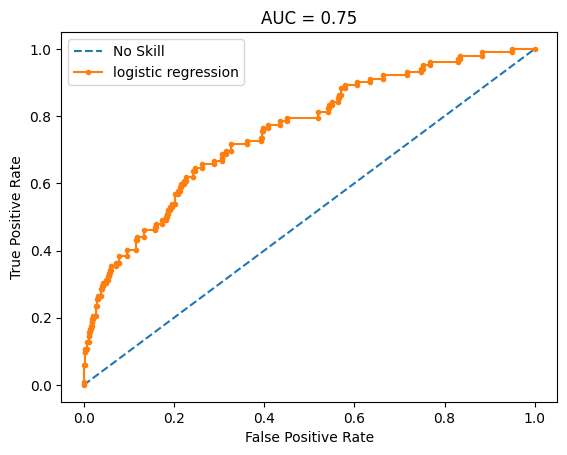

In [119]:
ns_probs = [0 for _ in range(len(y_test))]
lr_probs = lr_model.predict_proba(X_test)
lr_probs = lr_probs[:, 1]
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='logistic regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC = %.2f' % auc(lr_fpr, lr_tpr))
plt.legend()
plt.show()

**K-Nearest Neighbors**

* **RandomSampler + KNN**

In [120]:
ros = RandomOverSampler(random_state=42)
X_ros, y_ros = ros.fit_resample(X_train, y_train)

In [121]:
knn_model = KNeighborsClassifier(weights='uniform').fit(X_ros, y_ros)
X_ros = pd.DataFrame(X_ros, columns = X_train.columns)
knn_y_predict = knn_model.predict(X_test)

print('ROCAUC score:', roc_auc_score(y_test, knn_y_predict))
print('Recall score:',recall_score(y_test, knn_y_predict))
print('\n', classification_report(y_test, knn_y_predict))
print('\n', confusion_matrix(y_test, knn_y_predict))

ROCAUC score: 0.6131025326797386
Recall score: 0.5196078431372549

               precision    recall  f1-score   support

           0       0.89      0.71      0.79       576
           1       0.24      0.52      0.33       102

    accuracy                           0.68       678
   macro avg       0.57      0.61      0.56       678
weighted avg       0.79      0.68      0.72       678


 [[407 169]
 [ 49  53]]


 * **StratifiedKFold + oversampling + KNN**

In [122]:
 knn_model = KNeighborsClassifier()
kf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
i=0
for train_index, valid_index in kf.split(X_train,y_train):
  X_train_cv, X_test_cv, y_train_cv, y_test_cv = X_train.values[train_index,:], X_train.values[valid_index,:], y_train.values[train_index], y_train.values[valid_index]
  ros = RandomOverSampler(random_state=42)
  X_ros, y_ros = ros.fit_resample(X_train_cv, y_train_cv)
  knn_model.fit(X_ros, y_ros)
  knn_predict = knn_model.predict(X_test_cv)
  print(f'CV {i+1}: ', recall_score(y_test_cv, knn_predict))
  i+=1

knn_y_predict = knn_model.predict(X_test)
print('\nTest results:')
print('ROCAUC score:', roc_auc_score(y_test, knn_y_predict))
print('Recall score:',recall_score(y_test, knn_y_predict))
print('\n', classification_report(y_test, knn_y_predict))

CV 1:  0.3902439024390244
CV 2:  0.4268292682926829
CV 3:  0.43209876543209874
CV 4:  0.4268292682926829
CV 5:  0.45121951219512196

Test results:
ROCAUC score: 0.5952308006535948
Recall score: 0.4803921568627451

               precision    recall  f1-score   support

           0       0.89      0.71      0.79       576
           1       0.23      0.48      0.31       102

    accuracy                           0.68       678
   macro avg       0.56      0.60      0.55       678
weighted avg       0.79      0.68      0.72       678



* **SMOTE + KNN**

In [123]:
smote = SMOTE()
X_smote, y_smote = smote.fit_resample(X_train, y_train)
knn_model = KNeighborsClassifier().fit(X_smote, y_smote)
X_smote = pd.DataFrame(X_smote, columns = X_train.columns)
knn_y_predict = knn_model.predict(X_test)

print('ROCAUC score:', roc_auc_score(y_test, knn_y_predict))
print('Recall score:',recall_score(y_test, knn_y_predict))
print('\n', classification_report(y_test, knn_y_predict))
print('\n', confusion_matrix(y_test, knn_y_predict))

ROCAUC score: 0.6153492647058824
Recall score: 0.5588235294117647

               precision    recall  f1-score   support

           0       0.90      0.67      0.77       576
           1       0.23      0.56      0.33       102

    accuracy                           0.65       678
   macro avg       0.56      0.62      0.55       678
weighted avg       0.80      0.65      0.70       678


 [[387 189]
 [ 45  57]]


* **GridSearch CV on KNN**

In [124]:
params = {
    'n_neighbors' : range(3,10,1),
    'weights' : ['uniform', 'distance']
    }

In [125]:
knn_model = KNeighborsClassifier()
grid_model = GridSearchCV(knn_model,param_grid=params,scoring='recall',cv=5)
grid_model.fit(X_ros,y_ros)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(3, 10),
                         'weights': ['uniform', 'distance']},
             scoring='recall')

In [126]:
grid_model.best_params_

{'n_neighbors': 3, 'weights': 'distance'}

In [127]:
knn_model = grid_model.best_estimator_

In [128]:
knn_y_predict = knn_model.predict(X_test)

print('ROCAUC score:', roc_auc_score(y_test, knn_y_predict))
print('Recall score:',recall_score(y_test, knn_y_predict))
print('\n', classification_report(y_test, knn_y_predict))
print('\n', confusion_matrix(y_test, knn_y_predict))

ROCAUC score: 0.5887459150326796
Recall score: 0.38235294117647056

               precision    recall  f1-score   support

           0       0.88      0.80      0.84       576
           1       0.25      0.38      0.30       102

    accuracy                           0.73       678
   macro avg       0.56      0.59      0.57       678
weighted avg       0.78      0.73      0.75       678


 [[458 118]
 [ 63  39]]


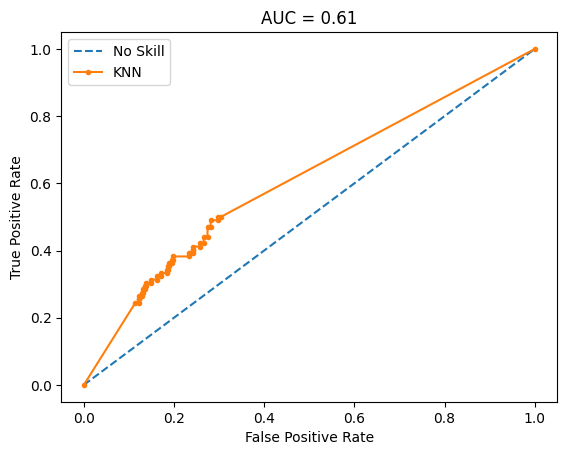

In [129]:
ns_probs = [0 for _ in range(len(y_test))]
knn_probs = knn_model.predict_proba(X_test)
knn_probs = knn_probs[:, 1]
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
knn_fpr, knn_tpr, _ = roc_curve(y_test, knn_probs)
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(knn_fpr, knn_tpr, marker='.', label='KNN')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC = %.2f' % auc(knn_fpr, knn_tpr))
plt.legend()
plt.show()

**Support Vector Machines**

* **Using the imabalnced dataset in SVC with class_weight='balanced', i.e. penalizing misclassifications in each class approriately !**

In [130]:
# we can add class_weight='balanced' to add penalize mistake
svc_model = SVC(class_weight='balanced', probability=True)

svc_model.fit(X_train, y_train)

svc_predict = svc_model.predict(X_test)
print('ROCAUC score:',roc_auc_score(y_test, svc_predict))
print('Recall score:',recall_score(y_test, svc_predict))
print('\n', classification_report(y_test, svc_predict))
print('\n', confusion_matrix(y_test, svc_predict))

ROCAUC score: 0.6926572712418301
Recall score: 0.696078431372549

               precision    recall  f1-score   support

           0       0.93      0.69      0.79       576
           1       0.28      0.70      0.40       102

    accuracy                           0.69       678
   macro avg       0.61      0.69      0.60       678
weighted avg       0.83      0.69      0.73       678


 [[397 179]
 [ 31  71]]


* **Random over-sampler + SVC**

In [131]:
svc_model = SVC(probability=True).fit(X_ros, y_ros)
X_ros = pd.DataFrame(X_ros, columns = X_train.columns)
svc_y_predict = svc_model.predict(X_test)

print('ROCAUC score:', roc_auc_score(y_test, svc_y_predict))
print('Recall score:',recall_score(y_test, svc_y_predict))
print('\n', classification_report(y_test, svc_y_predict))
print('\n', confusion_matrix(y_test, svc_y_predict))

ROCAUC score: 0.6765216503267973
Recall score: 0.6568627450980392

               precision    recall  f1-score   support

           0       0.92      0.70      0.79       576
           1       0.28      0.66      0.39       102

    accuracy                           0.69       678
   macro avg       0.60      0.68      0.59       678
weighted avg       0.82      0.69      0.73       678


 [[401 175]
 [ 35  67]]


* **StratifiedKFold + oversampling + SVC**

In [132]:
 svc_model = SVC(probability=True)
kf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
i=0
for train_index, valid_index in kf.split(X_train,y_train):
  X_train_cv, X_test_cv, y_train_cv, y_test_cv = X_train.values[train_index,:], X_train.values[valid_index,:], y_train.values[train_index], y_train.values[valid_index]
  ros = RandomOverSampler(random_state=42)
  X_ros, y_ros = ros.fit_resample(X_train_cv, y_train_cv)
  svc_model.fit(X_ros, y_ros)
  svc_predict = svc_model.predict(X_test_cv)
  print(f'CV {i+1}: ', recall_score(y_test_cv, svc_predict))
  i+=1

svc_y_predict = svc_model.predict(X_test)
print('\nTest results:')
print('ROCAUC score:', roc_auc_score(y_test, svc_y_predict))
print('Recall score:',recall_score(y_test, svc_y_predict))
print('\n', classification_report(y_test, svc_y_predict))

CV 1:  0.5365853658536586
CV 2:  0.6097560975609756
CV 3:  0.48148148148148145
CV 4:  0.524390243902439
CV 5:  0.5853658536585366

Test results:
ROCAUC score: 0.6765216503267973
Recall score: 0.6568627450980392

               precision    recall  f1-score   support

           0       0.92      0.70      0.79       576
           1       0.28      0.66      0.39       102

    accuracy                           0.69       678
   macro avg       0.60      0.68      0.59       678
weighted avg       0.82      0.69      0.73       678



* **SMOTE + SVC**

In [133]:
smote = SMOTE()
X_smote, y_smote = smote.fit_resample(X_train, y_train)
svc_model = SVC(probability=True).fit(X_smote, y_smote)
X_smote = pd.DataFrame(X_smote, columns = X_train.columns)
svc_y_predict = svc_model.predict(X_test)

print('ROCAUC score:', roc_auc_score(y_test, svc_y_predict))
print('Recall score:',recall_score(y_test, svc_y_predict))
print('\n', classification_report(y_test, svc_y_predict))
print('\n', confusion_matrix(y_test, svc_y_predict))

ROCAUC score: 0.6436376633986929
Recall score: 0.5980392156862745

               precision    recall  f1-score   support

           0       0.91      0.69      0.78       576
           1       0.25      0.60      0.36       102

    accuracy                           0.68       678
   macro avg       0.58      0.64      0.57       678
weighted avg       0.81      0.68      0.72       678


 [[397 179]
 [ 41  61]]


* **GridSearchCV on SVC**

In [134]:
params = {'C' : [0.001, 0.01, 0.1, 1., 10., 100., 1.e+3]}

In [135]:
svc_model = SVC(class_weight='balanced',probability=True)
grid_model = GridSearchCV(svc_model,param_grid=params,scoring='recall',cv=5)
grid_model.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=SVC(class_weight='balanced', probability=True),
             param_grid={'C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]},
             scoring='recall')

In [136]:
grid_model.best_params_

{'C': 0.1}

In [137]:
svc_model = grid_model.best_estimator_

In [138]:
svc_y_predict = svc_model.predict(X_test)

print('ROCAUC score:', roc_auc_score(y_test, svc_y_predict))
print('Recall score:',recall_score(y_test, svc_y_predict))
print('\n', classification_report(y_test, svc_y_predict))
print('\n', confusion_matrix(y_test, svc_y_predict))

ROCAUC score: 0.6772875816993464
Recall score: 0.7156862745098039

               precision    recall  f1-score   support

           0       0.93      0.64      0.76       576
           1       0.26      0.72      0.38       102

    accuracy                           0.65       678
   macro avg       0.59      0.68      0.57       678
weighted avg       0.83      0.65      0.70       678


 [[368 208]
 [ 29  73]]


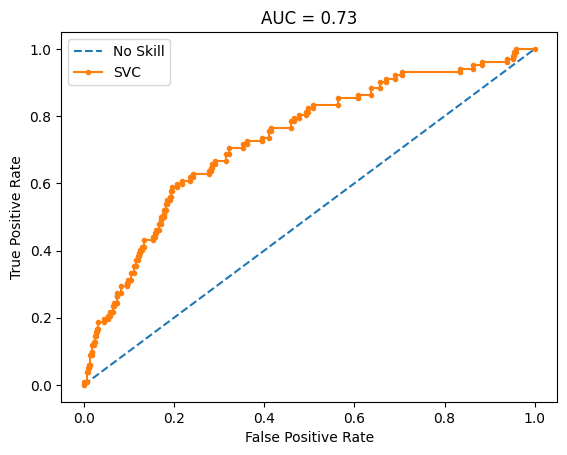

In [139]:
ns_probs = [0 for _ in range(len(y_test))]
svc_probs = svc_model.predict_proba(X_test)
svc_probs = svc_probs[:, 1]
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
svc_fpr, svc_tpr, _ = roc_curve(y_test, svc_probs)
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(svc_fpr, svc_tpr, marker='.', label='SVC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC = %.2f' % auc(svc_fpr, svc_tpr))
plt.legend()
plt.show()

**XGBoost Classifier**

* **Over-sampler + XGBoost**

In [140]:
ros = RandomOverSampler(random_state=42)
X_ros, y_ros = ros.fit_resample(X_train, y_train)

In [141]:

X_ros = pd.DataFrame(X_ros, columns = X_train.columns)
xgb_model = XGBClassifier(probability=True).fit(X_ros,y_ros)
xgb_y_predict = xgb_model.predict(X_test)

print('ROCAUC score:', roc_auc_score(y_test, xgb_y_predict))
print('Recall score:',recall_score(y_test, xgb_y_predict))
print('\n', classification_report(y_test, xgb_y_predict))
print('\n', confusion_matrix(y_test, xgb_y_predict))

[19:49:46] WARNING: ../src/learner.cc:767: 
Parameters: { "probability" } are not used.

ROCAUC score: 0.5800142973856209
Recall score: 0.24509803921568626

               precision    recall  f1-score   support

           0       0.87      0.91      0.89       576
           1       0.34      0.25      0.28       102

    accuracy                           0.81       678
   macro avg       0.61      0.58      0.59       678
weighted avg       0.79      0.81      0.80       678


 [[527  49]
 [ 77  25]]


* **GridSearchCV on XGBoost**

In [142]:
params = {
  'max_depth' : range(3,11),
  'gamma' : [0.01, 0.05, 0.1, 0.5, 1.]
}

In [143]:
xgb_model = XGBClassifier(probability=True)
grid_model = GridSearchCV(xgb_model,param_grid=params,scoring='recall',cv=5)
grid_model.fit(X_ros,y_ros)

[19:49:54] WARNING: ../src/learner.cc:767: 
Parameters: { "probability" } are not used.

[19:49:55] WARNING: ../src/learner.cc:767: 
Parameters: { "probability" } are not used.

[19:49:55] WARNING: ../src/learner.cc:767: 
Parameters: { "probability" } are not used.

[19:49:55] WARNING: ../src/learner.cc:767: 
Parameters: { "probability" } are not used.

[19:49:55] WARNING: ../src/learner.cc:767: 
Parameters: { "probability" } are not used.

[19:49:55] WARNING: ../src/learner.cc:767: 
Parameters: { "probability" } are not used.

[19:49:56] WARNING: ../src/learner.cc:767: 
Parameters: { "probability" } are not used.

[19:49:56] WARNING: ../src/learner.cc:767: 
Parameters: { "probability" } are not used.

[19:49:57] WARNING: ../src/learner.cc:767: 
Parameters: { "probability" } are not used.

[19:49:57] WARNING: ../src/learner.cc:767: 
Parameters: { "probability" } are not used.

[19:50:00] WARNING: ../src/learner.cc:767: 
Parameters: { "probability" } are not used.

[19:50:01] WARNING: .

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     probability=True, ...),
             param_grid={'gamma': [0.01, 0.05, 0.1, 0.5, 1.0],
                         'max_depth': range(3, 11)},
             scoring='recall')

In [ ]:
xgb_model = grid_model.best_estimator_

In [ ]:
xgb_y_predict = xgb_model.predict(X_test)

print('ROCAUC score:', roc_auc_score(y_test, xgb_y_predict))
print('Recall score:',recall_score(y_test, xgb_y_predict))
print('\n', classification_report(y_test, xgb_y_predict))
print('\n', confusion_matrix(y_test, xgb_y_predict))

ROCAUC score: 0.5906862745098038
Recall score: 0.2647058823529412

               precision    recall  f1-score   support

           0       0.88      0.92      0.90       576
           1       0.36      0.26      0.31       102

    accuracy                           0.82       678
   macro avg       0.62      0.59      0.60       678
weighted avg       0.80      0.82      0.81       678


 [[528  48]
 [ 75  27]]


# **Conclusion**

**We have used Logistic Regression, KNN, SVC and XGBoost for modelling. Based on our observations, Support vector classifier seems to have performed better with a recall of 0.75, after some hyper-parameter tuning. However the precision of our models still remains a concern.**

**Scope for improvement : Need to work on improving the precision (currently $\sim$ 0.26) of your model to some extent !**